Load Data

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [15]:
# ============================================================================
# CELL 2: FUNGSI LOAD DATA
# ============================================================================

def parse_datetime_safe(col):
    """
    Parse datetime dengan format YYYY/MM/DD HH:MM:SS
    """
    col = col.astype(str).str.strip()
    
    # Format di Excel: 2025/07/01 00:08:47
    parsed = pd.to_datetime(col, format='%Y/%m/%d %H:%M:%S', errors='coerce')
    
    # Jika gagal, coba format alternatif
    if parsed.isna().sum() > len(col) * 0.5:
        parsed = pd.to_datetime(col, format='%d/%m/%Y %H:%M:%S', errors='coerce', dayfirst=True)
    
    # Jika masih gagal, gunakan auto-detect
    if parsed.isna().sum() > len(col) * 0.5:
        parsed = pd.to_datetime(col, errors='coerce')
    
    return parsed


def load_data_baru(filepath, sheet_name='W9371UM LAMA'):
    """
    Load data LAMA dari Excel
    Sheet 'W9371UM LAMA' berisi data Juli - September 2025
    """
    print("="*80)
    print(f"LOADING DATA: {sheet_name}")
    print("="*80)
    
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    print(f"\n[1/5] Data loaded: {len(df):,} rows")
    
    print("[2/5] Parsing GPSTIME...")
    df['GPSTIME'] = parse_datetime_safe(df['GPSTIME'])
    
    if 'RECEIVE TIME' in df.columns:
        df['RECEIVE TIME'] = parse_datetime_safe(df['RECEIVE TIME'])
    
    print("[3/5] Converting numeric columns...")
    df['VALUE FUEL SENSOR'] = pd.to_numeric(df['VALUE FUEL SENSOR'], errors='coerce')
    df['VOLTAGE FUEL SENSOR'] = pd.to_numeric(df['VOLTAGE FUEL SENSOR'], errors='coerce')
    df['ODOMETER'] = pd.to_numeric(df['ODOMETER'], errors='coerce')
    df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
    
    print("[4/5] Removing invalid rows...")
    initial_count = len(df)
    df = df.dropna(subset=['GPSTIME'])
    removed = initial_count - len(df)
    if removed > 0:
        print(f"    Removed {removed} rows with invalid GPSTIME")
    
    print("[5/5] Sorting and filtering...")
    df = df.sort_values('GPSTIME').reset_index(drop=True)
    df_active = df[df['ACC'] == 'ON'].copy()
    
    print("\n" + "-"*80)
    print(f"Total data                : {len(df):,}")
    print(f"Data ACC ON               : {len(df_active):,}")
    
    if len(df_active) > 0:
        print(f"Rentang waktu             : {df_active['GPSTIME'].min()} s/d {df_active['GPSTIME'].max()}")
        
        months = sorted(df_active['GPSTIME'].dt.month.unique())
        month_names = {7: 'Juli', 8: 'Agustus', 9: 'September'}
        print(f"Bulan                     : {[month_names.get(m, f'Bulan {m}') for m in months]}")
        
        unique_dates = df_active['GPSTIME'].dt.date.nunique()
        print(f"Jumlah hari unik          : {unique_dates} hari")
        
        print(f"\nBreakdown per bulan:")
        for month in months:
            month_data = df_active[df_active['GPSTIME'].dt.month == month]
            month_days = month_data['GPSTIME'].dt.date.nunique()
            print(f"  • {month_names.get(month, f'Bulan {month}')}: {month_days} hari ({len(month_data):,} records)")
    else:
        print("WARNING: Tidak ada data dengan ACC ON!")
    
    print("="*80)
    return df, df_active


# LOAD DATA
filepath = 'Data W9371UM ULTRASONIK.xlsx'
df_baru, df_lama_active = load_data_baru(filepath, sheet_name='W9371UM LAMA')

LOADING DATA: W9371UM LAMA

[1/5] Data loaded: 25,727 rows
[2/5] Parsing GPSTIME...
[3/5] Converting numeric columns...
[4/5] Removing invalid rows...
[5/5] Sorting and filtering...

--------------------------------------------------------------------------------
Total data                : 25,727
Data ACC ON               : 22,227
Rentang waktu             : 2025-07-02 09:14:34 s/d 2025-09-02 09:44:59
Bulan                     : ['Juli', 'Agustus', 'September']
Jumlah hari unik          : 45 hari

Breakdown per bulan:
  • Juli: 17 hari (8,156 records)
  • Agustus: 26 hari (13,334 records)
  • September: 2 hari (737 records)


In [16]:
# ============================================================================
# CELL 3: FUNGSI CALCULATE FUEL CONSUMPTION
# ============================================================================

def calculate_fuel_consumption(df, min_distance=0.5, min_fuel=0.2, min_consumption=1, max_consumption=20):
    """
    Menghitung konsumsi BBM per trip dengan filter yang konsisten
    """
    print("\n" + "="*80)
    print("ANALISIS KONSUMSI BBM PER TRIP")
    print("="*80)
    
    df = df.copy()
    
    df['time_diff'] = df['GPSTIME'].diff().dt.total_seconds() / 60
    df['odo_diff'] = df['ODOMETER'].diff()
    df['fuel_diff'] = df['VALUE FUEL SENSOR'].diff()
    
    df['new_trip'] = ((df['time_diff'] > 60) | (df['odo_diff'] < 0) | (df['fuel_diff'] > 10))
    df['trip_id'] = df['new_trip'].cumsum()
    
    trip_list = []
    
    for trip_id, trip_data in df.groupby('trip_id'):
        if len(trip_data) < 2:
            continue
        
        start_odo = trip_data['ODOMETER'].iloc[0]
        end_odo = trip_data['ODOMETER'].iloc[-1]
        distance = end_odo - start_odo
        
        start_fuel = trip_data['VALUE FUEL SENSOR'].iloc[0]
        end_fuel = trip_data['VALUE FUEL SENSOR'].iloc[-1]
        fuel_used = start_fuel - end_fuel
        
        if distance > min_distance and fuel_used > min_fuel:
            consumption = distance / fuel_used
            
            if min_consumption <= consumption <= max_consumption:
                duration_hours = (trip_data['GPSTIME'].iloc[-1] - trip_data['GPSTIME'].iloc[0]).total_seconds() / 3600
                
                trip_list.append({
                    'trip_id': trip_id,
                    'start_time': trip_data['GPSTIME'].iloc[0],
                    'end_time': trip_data['GPSTIME'].iloc[-1],
                    'duration_hours': duration_hours,
                    'distance_km': distance,
                    'fuel_used_L': fuel_used,
                    'consumption_kmL': consumption,
                    'avg_speed': trip_data['SPEED'].mean(),
                    'max_speed': trip_data['SPEED'].max(),
                    'data_points': len(trip_data)
                })
    
    result = pd.DataFrame(trip_list)
    
    print(f"\nParameter Filter:")
    print(f"  - Jarak minimal       : {min_distance} km")
    print(f"  - BBM minimal         : {min_fuel} L")
    print(f"  - Konsumsi range      : {min_consumption}-{max_consumption} km/L")
    print(f"  - Gap waktu trip baru : > 60 menit")
    
    if len(result) > 0:
        print(f"\nHasil:")
        print(f"  - Total trip valid    : {len(result)}")
        print(f"  - Rata-rata konsumsi  : {result['consumption_kmL'].mean():.4f} km/L")
        print(f"  - Std deviasi         : {result['consumption_kmL'].std():.4f} km/L")
        print(f"  - Min konsumsi        : {result['consumption_kmL'].min():.4f} km/L")
        print(f"  - Max konsumsi        : {result['consumption_kmL'].max():.4f} km/L")
    else:
        print("\nWARNING: Tidak ada trip valid terdeteksi dengan filter ini!")
    
    print("="*80)
    return result


# CALCULATE TRIPS
trips_baru = calculate_fuel_consumption(df_baru_active)


ANALISIS KONSUMSI BBM PER TRIP

Parameter Filter:
  - Jarak minimal       : 0.5 km
  - BBM minimal         : 0.2 L
  - Konsumsi range      : 1-20 km/L
  - Gap waktu trip baru : > 60 menit

Hasil:
  - Total trip valid    : 25
  - Rata-rata konsumsi  : 3.2799 km/L
  - Std deviasi         : 2.5589 km/L
  - Min konsumsi        : 1.4762 km/L
  - Max konsumsi        : 12.9731 km/L


In [17]:
# ============================================================================
# CELL 4: FUNGSI AGGREGATE DAILY
# ============================================================================

def aggregate_daily(trips_df):
    """
    Agregasi data per hari
    """
    print("\n" + "="*80)
    print("AGREGASI DATA HARIAN")
    print("="*80)
    
    if len(trips_df) == 0:
        print("\nWARNING: Tidak ada trip untuk diagregasi!")
        print("="*80)
        return pd.DataFrame()
    
    trips_df['date'] = trips_df['start_time'].dt.date
    
    daily_stats = trips_df.groupby('date').agg({
        'consumption_kmL': ['mean', 'std', 'min', 'max', 'count'],
        'distance_km': 'sum',
        'fuel_used_L': 'sum',
        'duration_hours': 'sum',
        'avg_speed': 'mean'
    }).reset_index()
    
    daily_stats.columns = ['date', 'avg_consumption_kmL', 'std_consumption_kmL', 
                           'min_consumption_kmL', 'max_consumption_kmL', 'num_trips',
                           'distance_km', 'fuel_used_L', 'duration_hours', 'avg_speed_kmh']
    
    print(f"\nHasil Agregasi:")
    print(f"  - Total hari dengan data : {len(daily_stats)}")
    print(f"  - Rentang tanggal        : {daily_stats['date'].min()} s/d {daily_stats['date'].max()}")
    print(f"  - Total trip             : {daily_stats['num_trips'].sum():.0f}")
    print(f"  - Total jarak            : {daily_stats['distance_km'].sum():.2f} km")
    print(f"  - Total BBM              : {daily_stats['fuel_used_L'].sum():.2f} L")
    print(f"  - Rata-rata konsumsi/hari: {daily_stats['avg_consumption_kmL'].mean():.4f} km/L")
    print("="*80)
    
    return daily_stats


# AGGREGATE DAILY
daily_baru = aggregate_daily(trips_baru)


AGREGASI DATA HARIAN

Hasil Agregasi:
  - Total hari dengan data : 22
  - Rentang tanggal        : 2025-07-08 s/d 2025-09-01
  - Total trip             : 25
  - Total jarak            : 710.10 km
  - Total BBM              : 249.84 L
  - Rata-rata konsumsi/hari: 3.1767 km/L


In [18]:
# ============================================================================
# CELL 5: INTERPOLASI UNTUK HARI YANG MISSING
# ============================================================================

def interpolate_missing_days(daily_df):
    """
    Interpolasi linear untuk hari-hari yang tidak ada data
    """
    print("\n" + "="*80)
    print("INTERPOLASI HARI YANG MISSING")
    print("="*80)
    
    if len(daily_df) == 0:
        print("\nWARNING: Tidak ada data untuk diinterpolasi!")
        print("="*80)
        return pd.DataFrame()
    
    date_range = pd.date_range(start=daily_df['date'].min(), end=daily_df['date'].max(), freq='D')
    full_dates = pd.DataFrame({'date': date_range.date})
    
    merged = full_dates.merge(daily_df, on='date', how='left')
    
    missing_days = merged['avg_consumption_kmL'].isna().sum()
    
    print(f"\nSebelum interpolasi:")
    print(f"  - Total hari dalam range : {len(full_dates)}")
    print(f"  - Hari dengan data       : {len(daily_df)}")
    print(f"  - Hari missing           : {missing_days}")
    
    if missing_days > 0:
        merged['avg_consumption_kmL'] = merged['avg_consumption_kmL'].interpolate(method='linear')
        merged['distance_km'] = merged['distance_km'].interpolate(method='linear')
        merged['fuel_used_L'] = merged['fuel_used_L'].interpolate(method='linear')
        merged['avg_speed_kmh'] = merged['avg_speed_kmh'].interpolate(method='linear')
        merged['num_trips'] = merged['num_trips'].fillna(0)
        
        print(f"\nSetelah interpolasi:")
        print(f"  - Semua hari terisi      : {len(merged)}")
        print(f"  - Metode                 : Linear interpolation")
        print(f"  - Rata-rata konsumsi     : {merged['avg_consumption_kmL'].mean():.4f} km/L")
    else:
        print(f"\nTidak ada hari yang missing, tidak perlu interpolasi")
    
    print("="*80)
    return merged


# INTERPOLATE
daily_baru_interpolated = interpolate_missing_days(daily_baru)


INTERPOLASI HARI YANG MISSING

Sebelum interpolasi:
  - Total hari dalam range : 56
  - Hari dengan data       : 22
  - Hari missing           : 34

Setelah interpolasi:
  - Semua hari terisi      : 56
  - Metode                 : Linear interpolation
  - Rata-rata konsumsi     : 3.2840 km/L


In [19]:
# ============================================================================
# CELL 6: STATISTIK DESKRIPTIF
# ============================================================================

def descriptive_statistics(daily_df):
    """
    Menghitung statistik deskriptif
    """
    print("\n" + "="*80)
    print("STATISTIK DESKRIPTIF KONSUMSI BBM HARIAN")
    print("="*80)
    
    if len(daily_df) == 0:
        print("\nWARNING: Tidak ada data untuk statistik!")
        print("="*80)
        return {}
    
    consumption = daily_df['avg_consumption_kmL'].values
    
    stats_dict = {
        'N': len(consumption),
        'Mean': np.mean(consumption),
        'Median': np.median(consumption),
        'Std_Dev': np.std(consumption, ddof=1),
        'Variance': np.var(consumption, ddof=1),
        'Min': np.min(consumption),
        'Max': np.max(consumption),
        'Range': np.max(consumption) - np.min(consumption),
        'Q1': np.percentile(consumption, 25),
        'Q3': np.percentile(consumption, 75),
        'IQR': np.percentile(consumption, 75) - np.percentile(consumption, 25),
        'Skewness': stats.skew(consumption),
        'Kurtosis': stats.kurtosis(consumption),
        'CV': (np.std(consumption, ddof=1) / np.mean(consumption)) * 100
    }
    
    print(f"\nUkuran Sampel:")
    print(f"  N                    : {stats_dict['N']}")
    
    print(f"\nTendensi Sentral:")
    print(f"  Mean                 : {stats_dict['Mean']:.4f} km/L")
    print(f"  Median               : {stats_dict['Median']:.4f} km/L")
    
    print(f"\nDispersi:")
    print(f"  Std Deviation        : {stats_dict['Std_Dev']:.4f} km/L")
    print(f"  Variance             : {stats_dict['Variance']:.4f}")
    print(f"  Range                : {stats_dict['Range']:.4f} km/L")
    print(f"  IQR                  : {stats_dict['IQR']:.4f} km/L")
    print(f"  Coefficient of Var   : {stats_dict['CV']:.2f}%")
    
    print(f"\nNilai Ekstrem:")
    print(f"  Minimum              : {stats_dict['Min']:.4f} km/L")
    print(f"  Q1 (25th percentile) : {stats_dict['Q1']:.4f} km/L")
    print(f"  Q3 (75th percentile) : {stats_dict['Q3']:.4f} km/L")
    print(f"  Maximum              : {stats_dict['Max']:.4f} km/L")
    
    print(f"\nBentuk Distribusi:")
    print(f"  Skewness             : {stats_dict['Skewness']:.4f}")
    if abs(stats_dict['Skewness']) < 0.5:
        print(f"                         (Distribusi simetris)")
    elif stats_dict['Skewness'] > 0.5:
        print(f"                         (Distribusi condong kanan/positif)")
    else:
        print(f"                         (Distribusi condong kiri/negatif)")
    
    print(f"  Kurtosis             : {stats_dict['Kurtosis']:.4f}")
    if abs(stats_dict['Kurtosis']) < 0.5:
        print(f"                         (Distribusi mesokurtik/normal)")
    elif stats_dict['Kurtosis'] > 0.5:
        print(f"                         (Distribusi leptokurtik/runcing)")
    else:
        print(f"                         (Distribusi platikurtik/datar)")
    
    print("="*80)
    return stats_dict


# CALCULATE STATISTICS
stats_baru_interpolated = descriptive_statistics(daily_baru_interpolated)


STATISTIK DESKRIPTIF KONSUMSI BBM HARIAN

Ukuran Sampel:
  N                    : 56

Tendensi Sentral:
  Mean                 : 3.2840 km/L
  Median               : 2.7021 km/L

Dispersi:
  Std Deviation        : 1.9175 km/L
  Variance             : 3.6768
  Range                : 11.4969 km/L
  IQR                  : 1.4788 km/L
  Coefficient of Var   : 58.39%

Nilai Ekstrem:
  Minimum              : 1.4762 km/L
  Q1 (25th percentile) : 2.1423 km/L
  Q3 (75th percentile) : 3.6211 km/L
  Maximum              : 12.9731 km/L

Bentuk Distribusi:
  Skewness             : 2.7223
                         (Distribusi condong kanan/positif)
  Kurtosis             : 10.0457
                         (Distribusi leptokurtik/runcing)


In [20]:
# ============================================================================
# CELL 7: UJI NORMALITAS
# ============================================================================

def test_normality(daily_df, alpha=0.05):
    """
    Uji normalitas dengan tiga metode
    """
    print("\n" + "="*80)
    print("UJI NORMALITAS DATA KONSUMSI BBM HARIAN")
    print("="*80)
    
    if len(daily_df) == 0:
        print("\nWARNING: Tidak ada data untuk uji normalitas!")
        print("="*80)
        return {}
    
    consumption = daily_df['avg_consumption_kmL'].values
    n = len(consumption)
    
    print(f"\nUkuran sampel (N): {n}")
    print(f"Alpha level: {alpha}")
    
    # Shapiro-Wilk Test
    print("\n" + "-"*80)
    print("1. SHAPIRO-WILK TEST")
    print("-"*80)
    shapiro_stat, shapiro_p = stats.shapiro(consumption)
    shapiro_normal = shapiro_p > alpha
    
    print(f"Statistik W    : {shapiro_stat:.6f}")
    print(f"p-value        : {shapiro_p:.6f}")
    print(f"Kesimpulan     : {'Data berdistribusi NORMAL' if shapiro_normal else 'Data TIDAK berdistribusi normal'}")
    print(f"                 (p-value {'>' if shapiro_normal else '<'} {alpha})")
    
    # Kolmogorov-Smirnov Test
    print("\n" + "-"*80)
    print("2. KOLMOGOROV-SMIRNOV TEST")
    print("-"*80)
    ks_stat, ks_p = stats.kstest(consumption, 'norm', args=(np.mean(consumption), np.std(consumption, ddof=1)))
    ks_normal = ks_p > alpha
    
    print(f"Statistik D    : {ks_stat:.6f}")
    print(f"p-value        : {ks_p:.6f}")
    print(f"Kesimpulan     : {'Data berdistribusi NORMAL' if ks_normal else 'Data TIDAK berdistribusi normal'}")
    print(f"                 (p-value {'>' if ks_normal else '<'} {alpha})")
    
    # Anderson-Darling Test
    print("\n" + "-"*80)
    print("3. ANDERSON-DARLING TEST")
    print("-"*80)
    anderson_result = stats.anderson(consumption, dist='norm')
    anderson_stat = anderson_result.statistic
    
    critical_value_5 = anderson_result.critical_values[2]
    anderson_normal = anderson_stat < critical_value_5
    
    print(f"Statistik A²   : {anderson_stat:.6f}")
    print(f"Critical value : {critical_value_5:.6f} (significance level 5%)")
    print(f"Kesimpulan     : {'Data berdistribusi NORMAL' if anderson_normal else 'Data TIDAK berdistribusi normal'}")
    print(f"                 (A² {'<' if anderson_normal else '>'} critical value)")
    
    # Kesimpulan akhir
    print("\n" + "="*80)
    print("KESIMPULAN AKHIR UJI NORMALITAS")
    print("="*80)
    
    normal_count = sum([shapiro_normal, ks_normal, anderson_normal])
    
    print(f"\nHasil uji yang menyatakan data NORMAL: {normal_count}/3")
    print(f"  - Shapiro-Wilk      : {'NORMAL' if shapiro_normal else 'TIDAK NORMAL'}")
    print(f"  - Kolmogorov-Smirnov: {'NORMAL' if ks_normal else 'TIDAK NORMAL'}")
    print(f"  - Anderson-Darling  : {'NORMAL' if anderson_normal else 'TIDAK NORMAL'}")
    
    if normal_count >= 2:
        conclusion = "Data berdistribusi NORMAL"
        recommendation = "Dapat menggunakan uji parametrik (t-test, ANOVA)"
    else:
        conclusion = "Data TIDAK berdistribusi normal"
        recommendation = "Sebaiknya menggunakan uji non-parametrik (Mann-Whitney, Kruskal-Wallis)"
    
    print(f"\nKesimpulan: {conclusion}")
    print(f"Rekomendasi: {recommendation}")
    print("="*80)
    
    return {
        'shapiro_statistic': shapiro_stat,
        'shapiro_p_value': shapiro_p,
        'shapiro_normal': shapiro_normal,
        'ks_statistic': ks_stat,
        'ks_p_value': ks_p,
        'ks_normal': ks_normal,
        'anderson_statistic': anderson_stat,
        'anderson_critical_value': critical_value_5,
        'anderson_normal': anderson_normal,
        'conclusion': conclusion,
        'recommendation': recommendation,
        'normal_count': normal_count
    }


# TEST NORMALITY
normality_baru_interpolated = test_normality(daily_baru_interpolated)


UJI NORMALITAS DATA KONSUMSI BBM HARIAN

Ukuran sampel (N): 56
Alpha level: 0.05

--------------------------------------------------------------------------------
1. SHAPIRO-WILK TEST
--------------------------------------------------------------------------------
Statistik W    : 0.731673
p-value        : 0.000000
Kesimpulan     : Data TIDAK berdistribusi normal
                 (p-value < 0.05)

--------------------------------------------------------------------------------
2. KOLMOGOROV-SMIRNOV TEST
--------------------------------------------------------------------------------
Statistik D    : 0.202030
p-value        : 0.017629
Kesimpulan     : Data TIDAK berdistribusi normal
                 (p-value < 0.05)

--------------------------------------------------------------------------------
3. ANDERSON-DARLING TEST
--------------------------------------------------------------------------------
Statistik A²   : 3.762658
Critical value : 0.740000 (significance level 5%)
Kesimpulan

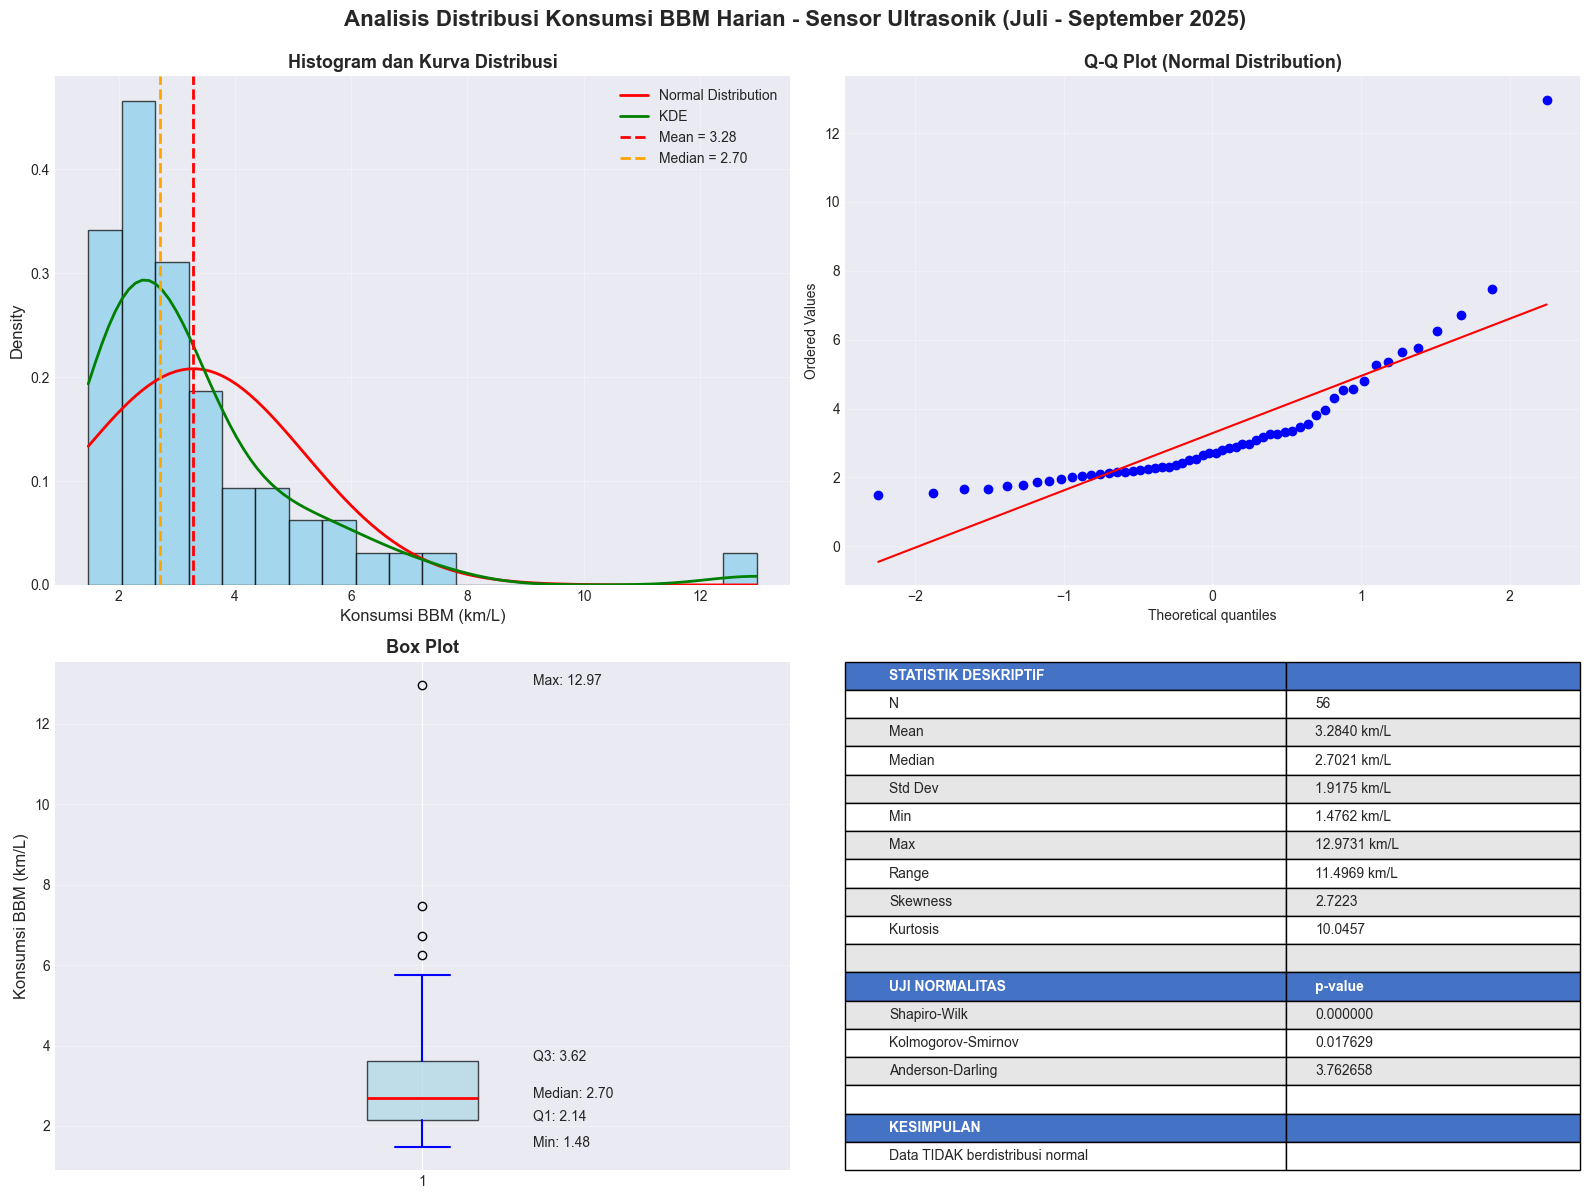


Visualisasi distribusi berhasil ditampilkan


In [21]:
# ============================================================================
# CELL 8: VISUALISASI DISTRIBUSI
# ============================================================================

def plot_consumption_distribution(daily_df, stats_dict, normality_dict, title_suffix=""):
    """
    Plot distribusi konsumsi BBM dengan 4 subplot
    """
    if len(daily_df) == 0:
        print("WARNING: Tidak ada data untuk divisualisasi!")
        return None
    
    consumption = daily_df['avg_consumption_kmL'].values
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Analisis Distribusi Konsumsi BBM Harian {title_suffix}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Histogram dengan KDE
    ax1 = axes[0, 0]
    ax1.hist(consumption, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    
    mu, sigma = stats_dict['Mean'], stats_dict['Std_Dev']
    x = np.linspace(consumption.min(), consumption.max(), 100)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
    
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(consumption)
    ax1.plot(x, kde(x), 'g-', linewidth=2, label='KDE')
    
    ax1.axvline(stats_dict['Mean'], color='red', linestyle='--', linewidth=2, label=f"Mean = {stats_dict['Mean']:.2f}")
    ax1.axvline(stats_dict['Median'], color='orange', linestyle='--', linewidth=2, label=f"Median = {stats_dict['Median']:.2f}")
    
    ax1.set_xlabel('Konsumsi BBM (km/L)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Histogram dan Kurva Distribusi', fontsize=13, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Q-Q Plot
    ax2 = axes[0, 1]
    stats.probplot(consumption, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot (Normal Distribution)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Box Plot
    ax3 = axes[1, 0]
    bp = ax3.boxplot(consumption, vert=True, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5))
    
    ax3.set_ylabel('Konsumsi BBM (km/L)', fontsize=12)
    ax3.set_title('Box Plot', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    y_pos = consumption.max() * 0.95
    ax3.text(1.15, stats_dict['Max'], f"Max: {stats_dict['Max']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Q3'], f"Q3: {stats_dict['Q3']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Median'], f"Median: {stats_dict['Median']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Q1'], f"Q1: {stats_dict['Q1']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Min'], f"Min: {stats_dict['Min']:.2f}", fontsize=10, ha='left')
    
    # Tabel Statistik dan Uji Normalitas
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    table_data = [
        ['STATISTIK DESKRIPTIF', ''],
        ['N', f"{stats_dict['N']}"],
        ['Mean', f"{stats_dict['Mean']:.4f} km/L"],
        ['Median', f"{stats_dict['Median']:.4f} km/L"],
        ['Std Dev', f"{stats_dict['Std_Dev']:.4f} km/L"],
        ['Min', f"{stats_dict['Min']:.4f} km/L"],
        ['Max', f"{stats_dict['Max']:.4f} km/L"],
        ['Range', f"{stats_dict['Range']:.4f} km/L"],
        ['Skewness', f"{stats_dict['Skewness']:.4f}"],
        ['Kurtosis', f"{stats_dict['Kurtosis']:.4f}"],
        ['', ''],
        ['UJI NORMALITAS', 'p-value'],
        ['Shapiro-Wilk', f"{normality_dict['shapiro_p_value']:.6f}"],
        ['Kolmogorov-Smirnov', f"{normality_dict['ks_p_value']:.6f}"],
        ['Anderson-Darling', f"{normality_dict['anderson_statistic']:.6f}"],
        ['', ''],
        ['KESIMPULAN', ''],
        [normality_dict['conclusion'], '']
    ]
    
    table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4], bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    for i in range(len(table_data)):
        if i in [0, 11, 16]:
            for j in range(2):
                table[(i, j)].set_facecolor('#4472C4')
                table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            for j in range(2):
                table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')
    
    plt.tight_layout()
    return fig


# PLOT DISTRIBUSI
if len(daily_baru_interpolated) > 0:
    fig1 = plot_consumption_distribution(
        daily_baru_interpolated,
        stats_baru_interpolated,
        normality_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Juli - September 2025)"
    )
    plt.show()
    print("\nVisualisasi distribusi berhasil ditampilkan")
else:
    print("\nTidak ada data untuk divisualisasi")


MEMBUAT DASHBOARD RINGKASAN - SENSOR ULTRASONIK
✓ Data daily tersedia: 56 hari
✓ Stats tersedia: 14 metrics
✓ Normalitas tersedia: 12 results

🎯 Membuat dashboard...


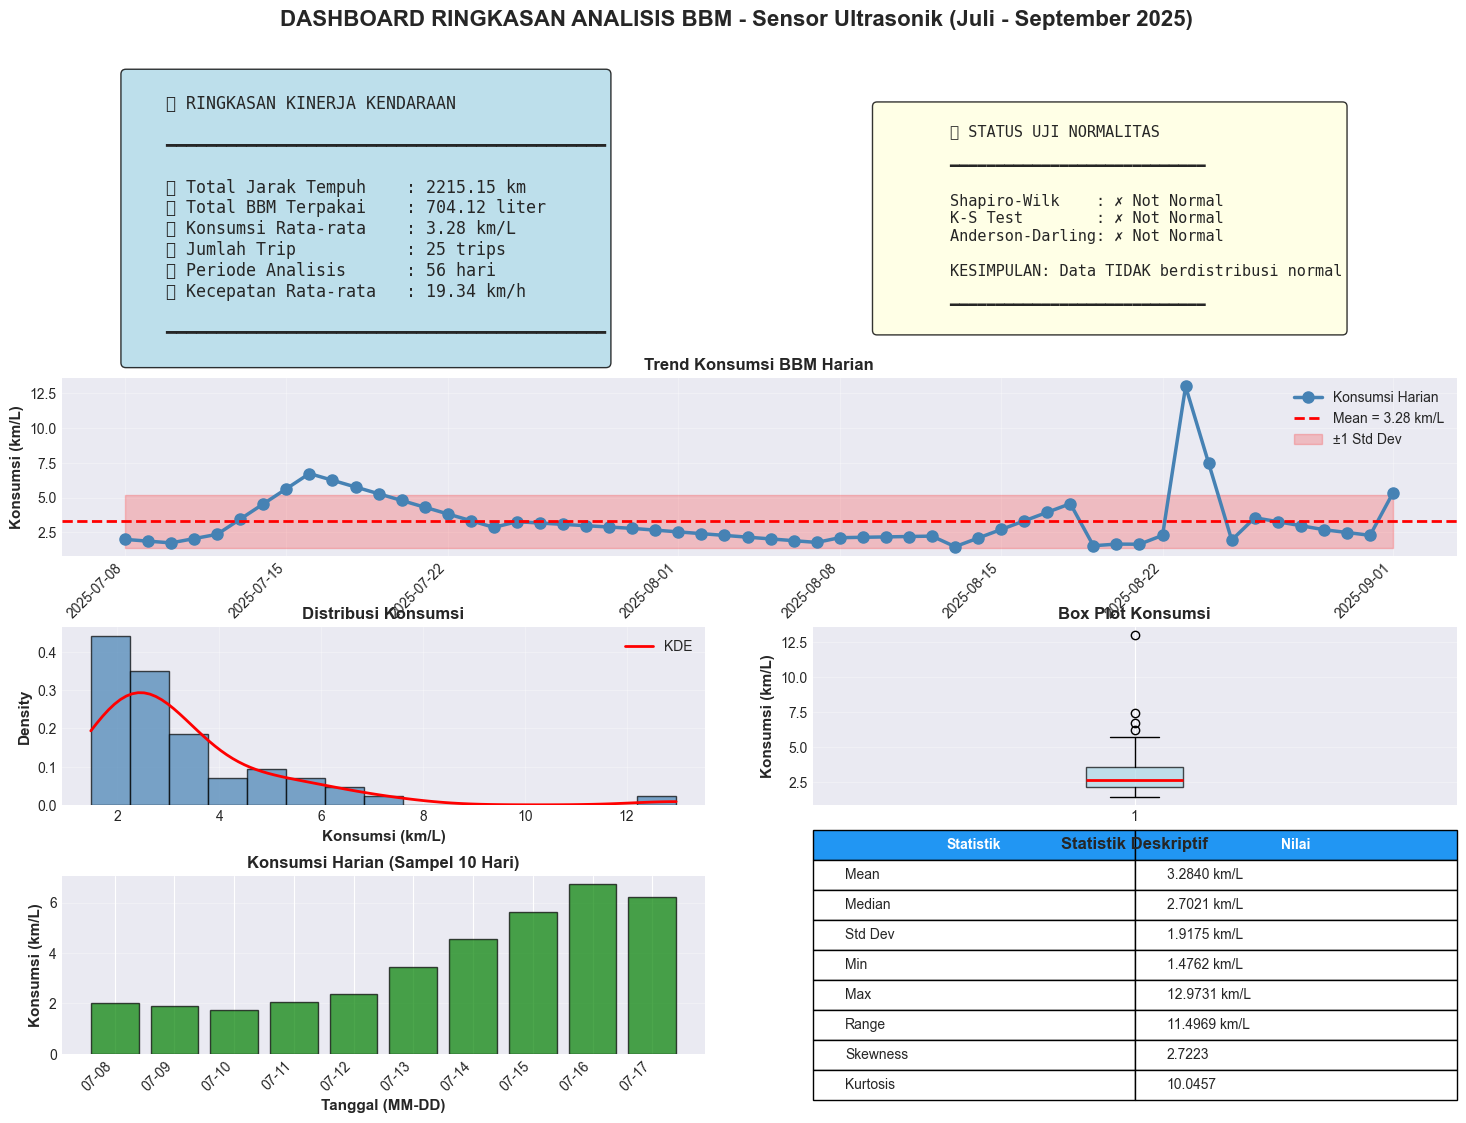


✅ Dashboard berhasil ditampilkan!


In [22]:
# ============================================================================
# PERBAIKAN FUNGSI CREATE_SUMMARY_DASHBOARD
# ============================================================================

def create_summary_dashboard_fixed(daily_df, stats_dict, normality_dict, title=""):
    """
    Dashboard ringkasan lengkap - VERSI DIPERBAIKI
    Parameter yang dibutuhkan:
    - daily_df: DataFrame data harian
    - stats_dict: Dictionary statistik deskriptif 
    - normality_dict: Dictionary hasil uji normalitas
    - title: String judul dashboard
    """
    # Validasi input
    if len(daily_df) == 0:
        print("ERROR: DataFrame daily kosong!")
        return None
        
    if not stats_dict:
        print("ERROR: Dictionary stats kosong!")
        return None
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.4)
    
    fig.suptitle(f'DASHBOARD RINGKASAN ANALISIS BBM {title}', 
                 fontsize=16, fontweight='bold')
    
    # 1. KEY METRICS (Top row - spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.axis('off')
    
    try:
        # Calculate key metrics dengan safe access
        total_distance = daily_df['distance_km'].sum() if 'distance_km' in daily_df.columns else 0
        total_fuel = daily_df['fuel_used_L'].sum() if 'fuel_used_L' in daily_df.columns else 0
        avg_consumption = stats_dict.get('Mean', 0)
        total_trips = daily_df['num_trips'].sum() if 'num_trips' in daily_df.columns else 0
        total_days = len(daily_df)
        # Perbaikan: gunakan avg_speed_kmh dari daily_df, bukan trip_df
        avg_speed = daily_df['avg_speed_kmh'].mean() if 'avg_speed_kmh' in daily_df.columns else 0
        
        metrics_text = f"""
    📊 RINGKASAN KINERJA KENDARAAN
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    🚗 Total Jarak Tempuh    : {total_distance:.2f} km
    ⛽ Total BBM Terpakai    : {total_fuel:.2f} liter
    📈 Konsumsi Rata-rata    : {avg_consumption:.2f} km/L
    🔢 Jumlah Trip           : {int(total_trips)} trips
    📅 Periode Analisis      : {total_days} hari
    🏃 Kecepatan Rata-rata   : {avg_speed:.2f} km/h
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        """
        
        ax1.text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    except Exception as e:
        ax1.text(0.1, 0.5, f"Error dalam key metrics: {str(e)}", 
                fontsize=12, color='red')
    
    # 2. NORMALITY STATUS (Top right)
    ax2 = fig.add_subplot(gs[0, 2:])
    ax2.axis('off')
    
    try:
        if normality_dict and len(normality_dict) > 0:
            normality_text = f"""
        📊 STATUS UJI NORMALITAS
        
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        
        Shapiro-Wilk    : {'✓ Normal' if normality_dict.get('shapiro_normal', False) else '✗ Not Normal'}
        K-S Test        : {'✓ Normal' if normality_dict.get('ks_normal', False) else '✗ Not Normal'}
        Anderson-Darling: {'✓ Normal' if normality_dict.get('anderson_normal', False) else '✗ Not Normal'}
        
        KESIMPULAN: {normality_dict.get('conclusion', 'Belum diuji')}
        
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
            """
            
            # Perbaikan pengecekan conclusion
            is_normal = 'berdistribusi NORMAL' in normality_dict.get('conclusion', '')
            color = 'lightgreen' if is_normal else 'lightyellow'
            
            ax2.text(0.1, 0.5, normality_text, fontsize=11, family='monospace',
                    verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
        else:
            ax2.text(0.1, 0.5, "Data normalitas tidak tersedia", 
                    fontsize=11, color='orange')
    except Exception as e:
        ax2.text(0.1, 0.5, f"Error normalitas: {str(e)}", 
                fontsize=11, color='red')
    
    # 3. CONSUMPTION TREND (Row 2, spans all columns)
    ax3 = fig.add_subplot(gs[1, :])
    
    try:
        dates = pd.to_datetime(daily_df['date'])
        consumption = daily_df['avg_consumption_kmL'].values
        
        ax3.plot(dates, consumption, 'o-', linewidth=2.5, markersize=8,
                color='steelblue', label='Konsumsi Harian')
        ax3.axhline(consumption.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean = {consumption.mean():.2f} km/L')
        
        # Perbaikan: hanya tambahkan std band jika ada variasi data
        if consumption.std() > 0:
            ax3.fill_between(dates,
                            consumption.mean() - consumption.std(),
                            consumption.mean() + consumption.std(),
                            alpha=0.2, color='red', label='±1 Std Dev')
        
        ax3.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
        ax3.set_title('Trend Konsumsi BBM Harian', fontsize=12, fontweight='bold')
        ax3.legend(loc='best')
        ax3.grid(alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
    except Exception as e:
        ax3.text(0.5, 0.5, f"Error trend plot: {str(e)}", 
                transform=ax3.transAxes, ha='center', color='red')
    
    # 4. DISTRIBUTION (Row 3, left)
    ax4 = fig.add_subplot(gs[2, :2])
    
    try:
        consumption = daily_df['avg_consumption_kmL'].values
        n_bins = max(5, min(15, len(consumption)//2))
        ax4.hist(consumption, bins=n_bins, 
                alpha=0.7, color='steelblue', edgecolor='black', density=True)
        
        # Add KDE jika data cukup
        if len(consumption) > 2:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(consumption)
            x_range = np.linspace(consumption.min(), consumption.max(), 100)
            ax4.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
            ax4.legend()
        
        ax4.set_xlabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
        ax4.set_title('Distribusi Konsumsi', fontsize=12, fontweight='bold')
        ax4.grid(alpha=0.3)
        
    except Exception as e:
        ax4.text(0.5, 0.5, f"Error distribusi: {str(e)}", 
                transform=ax4.transAxes, ha='center', color='red')
    
    # 5. BOX PLOT (Row 3, right)
    ax5 = fig.add_subplot(gs[2, 2:])
    
    try:
        consumption = daily_df['avg_consumption_kmL'].values
        bp = ax5.boxplot(consumption, vert=True, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
        
        ax5.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
        ax5.set_title('Box Plot Konsumsi', fontsize=12, fontweight='bold')
        ax5.grid(axis='y', alpha=0.3)
        
    except Exception as e:
        ax5.text(0.5, 0.5, f"Error box plot: {str(e)}", 
                transform=ax5.transAxes, ha='center', color='red')
    
    # 6. DAILY SUMMARY CHART (Row 4, left) - Mengganti trip summary
    ax6 = fig.add_subplot(gs[3, :2])
    
    try:
        # Chart sederhana dengan data harian
        dates_short = daily_df['date'].head(10)  # Ambil 10 hari pertama
        consumption_short = daily_df['avg_consumption_kmL'].head(10)
        
        bars = ax6.bar(range(len(dates_short)), consumption_short, 
                      color='green', alpha=0.7, edgecolor='black')
        
        ax6.set_xticks(range(len(dates_short)))
        # Format tanggal lebih pendek
        date_labels = [str(d)[-5:] if len(str(d)) > 5 else str(d) for d in dates_short]
        ax6.set_xticklabels(date_labels, rotation=45, ha='right')
        ax6.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
        ax6.set_xlabel('Tanggal (MM-DD)', fontsize=11, fontweight='bold')
        ax6.set_title(f'Konsumsi Harian (Sampel {len(dates_short)} Hari)', 
                     fontsize=12, fontweight='bold')
        ax6.grid(axis='y', alpha=0.3)
        
    except Exception as e:
        ax6.text(0.5, 0.5, f"Error summary chart: {str(e)}", 
                transform=ax6.transAxes, ha='center', color='red')
    
    # 7. STATISTICS TABLE (Row 4, right)
    ax7 = fig.add_subplot(gs[3, 2:])
    ax7.axis('off')
    
    try:
        if stats_dict:
            stats_data = [
                ['Mean', f"{stats_dict.get('Mean', 0):.4f} km/L"],
                ['Median', f"{stats_dict.get('Median', 0):.4f} km/L"],
                ['Std Dev', f"{stats_dict.get('Std_Dev', 0):.4f} km/L"],
                ['Min', f"{stats_dict.get('Min', 0):.4f} km/L"],
                ['Max', f"{stats_dict.get('Max', 0):.4f} km/L"],
                ['Range', f"{stats_dict.get('Range', 0):.4f} km/L"],
                ['Skewness', f"{stats_dict.get('Skewness', 0):.4f}"],
                ['Kurtosis', f"{stats_dict.get('Kurtosis', 0):.4f}"]
            ]
            
            table = ax7.table(cellText=stats_data, colLabels=['Statistik', 'Nilai'],
                             loc='center', cellLoc='left', colWidths=[0.5, 0.5])
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1.8)
            
            # Color header
            for i in range(2):
                table[(0, i)].set_facecolor('#2196F3')
                table[(0, i)].set_text_props(weight='bold', color='white')
            
            ax7.set_title('Statistik Deskriptif', fontsize=12, fontweight='bold', pad=20)
        else:
            ax7.text(0.5, 0.5, 'Statistik tidak tersedia', 
                    fontsize=11, ha='center')
            
    except Exception as e:
        ax7.text(0.5, 0.5, f"Error tabel: {str(e)}", 
                fontsize=11, color='red', ha='center')
    
    plt.tight_layout()
    return fig


# ============================================================================
# IMPLEMENTASI DASHBOARD YANG DIPERBAIKI
# ============================================================================

print("\n" + "="*80)
print("MEMBUAT DASHBOARD RINGKASAN - SENSOR ULTRASONIK")
print("="*80)

try:
    # Pastikan semua variabel tersedia
    if 'daily_baru_interpolated' in globals() and len(daily_baru_interpolated) > 0:
        print(f"✓ Data daily tersedia: {len(daily_baru_interpolated)} hari")
        
        # Pastikan stats tersedia
        if 'stats_baru_interpolated' not in globals() or not stats_baru_interpolated:
            print("⚠ Menghitung ulang statistik deskriptif...")
            stats_baru_interpolated = descriptive_statistics(daily_baru_interpolated)
        else:
            print(f"✓ Stats tersedia: {len(stats_baru_interpolated)} metrics")
        
        # Pastikan normality tersedia  
        if 'normality_baru_interpolated' not in globals() or not normality_baru_interpolated:
            print("⚠ Menghitung ulang uji normalitas...")
            normality_baru_interpolated = test_normality(daily_baru_interpolated)
        else:
            print(f"✓ Normalitas tersedia: {len(normality_baru_interpolated)} results")
        
        print("\n🎯 Membuat dashboard...")
        
        # Buat dashboard dengan parameter yang benar
        fig_dashboard = create_summary_dashboard_fixed(
            daily_baru_interpolated,           # daily_df
            stats_baru_interpolated,           # stats_dict
            normality_baru_interpolated,       # normality_dict
            title="- Sensor Ultrasonik (Juli - September 2025)"  # title
        )
        
        if fig_dashboard is not None:
            plt.show()
            print("\n✅ Dashboard berhasil ditampilkan!")
        else:
            print("\n❌ Dashboard gagal dibuat")
    
    else:
        print("❌ Data daily tidak tersedia atau kosong")
        if 'daily_baru_interpolated' not in globals():
            print("   - Variabel 'daily_baru_interpolated' tidak ada")
        else:
            print(f"   - Data kosong, length: {len(daily_baru_interpolated)}")

except Exception as e:
    print(f"\n❌ ERROR: {str(e)}")
    print("\nDetail error:")
    import traceback
    traceback.print_exc()

print("="*80)

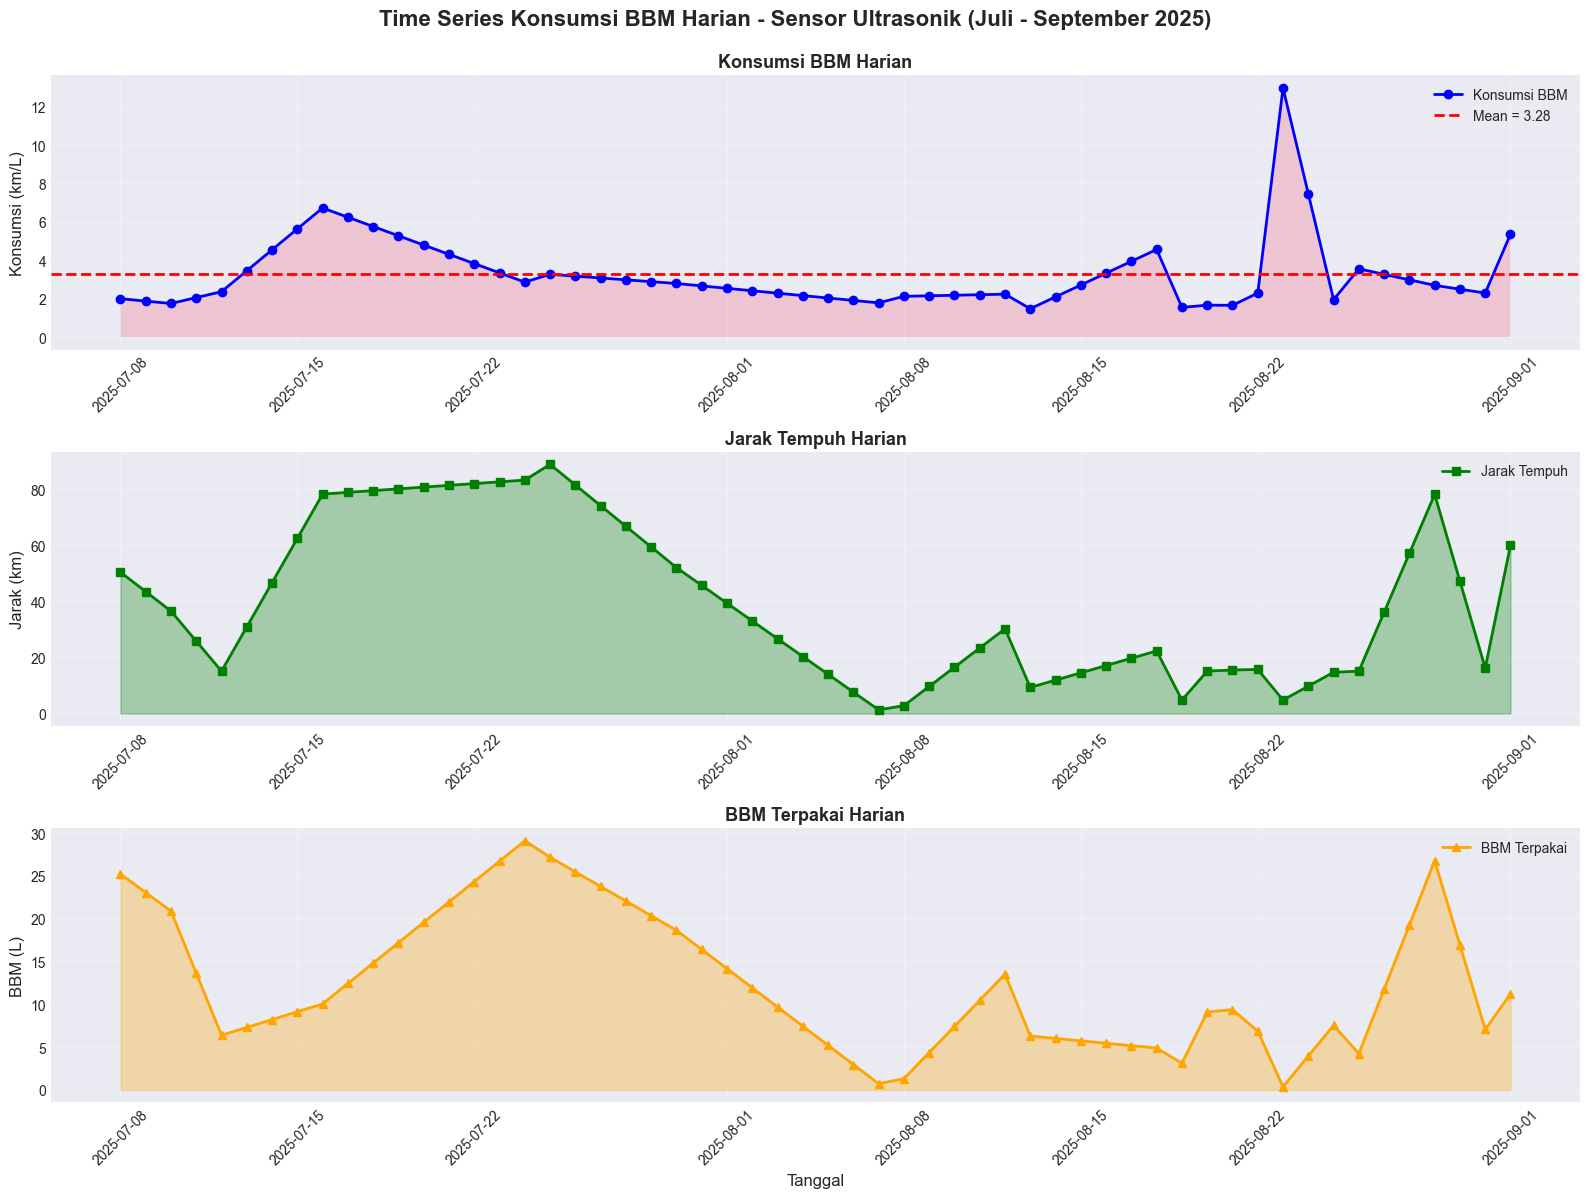


Visualisasi time series berhasil ditampilkan


In [ ]:
# ============================================================================
# CELL 9: VISUALISASI TIME SERIES
# ============================================================================

def plot_daily_timeseries(daily_df, title_suffix=""):
    """
    Plot time series konsumsi BBM harian
    """
    if len(daily_df) == 0:
        print("WARNING: Tidak ada data untuk divisualisasi!")
        return None
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f'Time Series Konsumsi BBM Harian {title_suffix}',
                 fontsize=16, fontweight='bold', y=0.995)
    
    dates = daily_df['date']
    
    # Konsumsi BBM
    ax1 = axes[0]
    ax1.plot(dates, daily_df['avg_consumption_kmL'], marker='o', linewidth=2, 
             markersize=6, color='blue', label='Konsumsi BBM')
    ax1.axhline(y=daily_df['avg_consumption_kmL'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Mean = {daily_df['avg_consumption_kmL'].mean():.2f}")
    ax1.fill_between(dates, daily_df['avg_consumption_kmL'], alpha=0.3)
    ax1.set_ylabel('Konsumsi (km/L)', fontsize=12)
    ax1.set_title('Konsumsi BBM Harian', fontsize=13, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Jarak Tempuh
    ax2 = axes[1]
    ax2.plot(dates, daily_df['distance_km'], marker='s', linewidth=2,
             markersize=6, color='green', label='Jarak Tempuh')
    ax2.fill_between(dates, daily_df['distance_km'], alpha=0.3, color='green')
    ax2.set_ylabel('Jarak (km)', fontsize=12)
    ax2.set_title('Jarak Tempuh Harian', fontsize=13, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # BBM Terpakai
    ax3 = axes[2]
    ax3.plot(dates, daily_df['fuel_used_L'], marker='^', linewidth=2,
             markersize=6, color='orange', label='BBM Terpakai')
    ax3.fill_between(dates, daily_df['fuel_used_L'], alpha=0.3, color='orange')
    ax3.set_xlabel('Tanggal', fontsize=12)
    ax3.set_ylabel('BBM (L)', fontsize=12)
    ax3.set_title('BBM Terpakai Harian', fontsize=13, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig


# PLOT TIME SERIES
if len(daily_baru_interpolated) > 0:
    fig2 = plot_daily_timeseries(
        daily_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Juli - September 2025)"
    )
    plt.show()
    print("\nVisualisasi time series berhasil ditampilkan")
else:
    print("\nTidak ada data untuk divisualisasi")

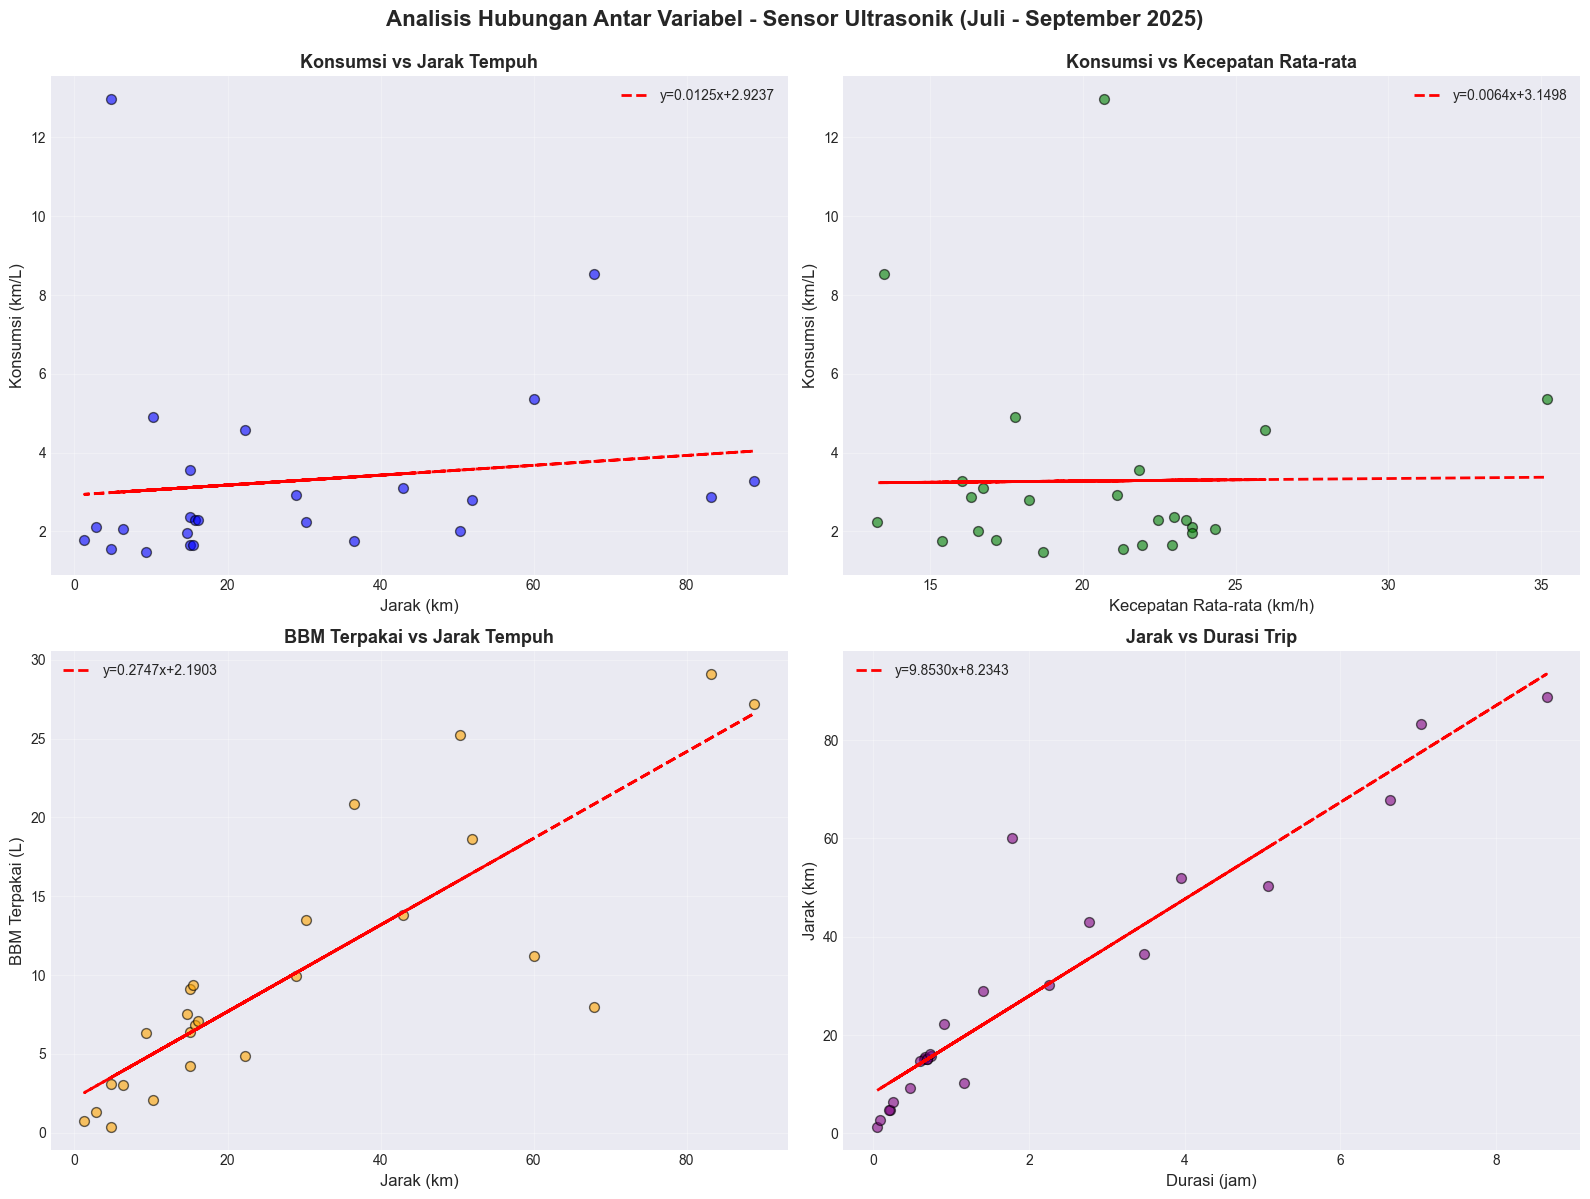


Visualisasi scatter plot berhasil ditampilkan


In [ ]:
# ============================================================================
# CELL 10: VISUALISASI SCATTER PLOT
# ============================================================================

def plot_scatter_analysis(trips_df, daily_df, title_suffix=""):
    """
    Plot scatter analysis untuk melihat hubungan antar variabel
    """
    if len(trips_df) == 0:
        print("WARNING: Tidak ada data trip untuk divisualisasi!")
        return None
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Analisis Hubungan Antar Variabel {title_suffix}',
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Konsumsi vs Jarak
    ax1 = axes[0, 0]
    ax1.scatter(trips_df['distance_km'], trips_df['consumption_kmL'],
                alpha=0.6, s=50, c='blue', edgecolors='black')
    z1 = np.polyfit(trips_df['distance_km'], trips_df['consumption_kmL'], 1)
    p1 = np.poly1d(z1)
    ax1.plot(trips_df['distance_km'], p1(trips_df['distance_km']),
             "r--", linewidth=2, label=f'y={z1[0]:.4f}x+{z1[1]:.4f}')
    ax1.set_xlabel('Jarak (km)', fontsize=12)
    ax1.set_ylabel('Konsumsi (km/L)', fontsize=12)
    ax1.set_title('Konsumsi vs Jarak Tempuh', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Konsumsi vs Kecepatan
    ax2 = axes[0, 1]
    ax2.scatter(trips_df['avg_speed'], trips_df['consumption_kmL'],
                alpha=0.6, s=50, c='green', edgecolors='black')
    z2 = np.polyfit(trips_df['avg_speed'], trips_df['consumption_kmL'], 1)
    p2 = np.poly1d(z2)
    ax2.plot(trips_df['avg_speed'], p2(trips_df['avg_speed']),
             "r--", linewidth=2, label=f'y={z2[0]:.4f}x+{z2[1]:.4f}')
    ax2.set_xlabel('Kecepatan Rata-rata (km/h)', fontsize=12)
    ax2.set_ylabel('Konsumsi (km/L)', fontsize=12)
    ax2.set_title('Konsumsi vs Kecepatan Rata-rata', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # BBM vs Jarak
    ax3 = axes[1, 0]
    ax3.scatter(trips_df['distance_km'], trips_df['fuel_used_L'],
                alpha=0.6, s=50, c='orange', edgecolors='black')
    z3 = np.polyfit(trips_df['distance_km'], trips_df['fuel_used_L'], 1)
    p3 = np.poly1d(z3)
    ax3.plot(trips_df['distance_km'], p3(trips_df['distance_km']),
             "r--", linewidth=2, label=f'y={z3[0]:.4f}x+{z3[1]:.4f}')
    ax3.set_xlabel('Jarak (km)', fontsize=12)
    ax3.set_ylabel('BBM Terpakai (L)', fontsize=12)
    ax3.set_title('BBM Terpakai vs Jarak Tempuh', fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Durasi vs Jarak
    ax4 = axes[1, 1]
    ax4.scatter(trips_df['duration_hours'], trips_df['distance_km'],
                alpha=0.6, s=50, c='purple', edgecolors='black')
    z4 = np.polyfit(trips_df['duration_hours'], trips_df['distance_km'], 1)
    p4 = np.poly1d(z4)
    ax4.plot(trips_df['duration_hours'], p4(trips_df['duration_hours']),
             "r--", linewidth=2, label=f'y={z4[0]:.4f}x+{z4[1]:.4f}')
    ax4.set_xlabel('Durasi (jam)', fontsize=12)
    ax4.set_ylabel('Jarak (km)', fontsize=12)
    ax4.set_title('Jarak vs Durasi Trip', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# PLOT SCATTER
if len(trips_baru) > 0:
    fig3 = plot_scatter_analysis(
        trips_baru,
        daily_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Juli - September 2025)"
    )
    plt.show()
    print("\nVisualisasi scatter plot berhasil ditampilkan")
else:
    print("\nTidak ada data untuk divisualisasi")

In [ ]:
# ============================================================================
# CELL 11: RANDOM SAMPLING 4 HARI
# ============================================================================

def random_sampling_days(daily_df, n_days=4, n_iterations=1000, random_state=42):
    """
    Random sampling untuk mengambil n hari secara acak dan menghitung statistik
    
    Parameters:
    - daily_df: DataFrame harian yang sudah diinterpolasi
    - n_days: Jumlah hari yang diambil per sampling (default 4)
    - n_iterations: Jumlah iterasi sampling (default 1000)
    - random_state: Seed untuk reprodusibilitas
    
    Returns:
    - DataFrame hasil sampling dengan statistik
    """
    print("\n" + "="*80)
    print(f"RANDOM SAMPLING {n_days} HARI")
    print("="*80)
    
    if len(daily_df) < n_days:
        print(f"\nERROR: Data hanya {len(daily_df)} hari, tidak cukup untuk sampling {n_days} hari!")
        print("="*80)
        return pd.DataFrame()
    
    np.random.seed(random_state)
    
    sampling_results = []
    
    print(f"\nParameter Sampling:")
    print(f"  - Jumlah hari per sample : {n_days}")
    print(f"  - Jumlah iterasi         : {n_iterations}")
    print(f"  - Total hari tersedia    : {len(daily_df)}")
    print(f"  - Random seed            : {random_state}")
    
    print(f"\nMelakukan sampling...")
    
    for i in range(n_iterations):
        sampled_indices = np.random.choice(len(daily_df), size=n_days, replace=False)
        sampled_data = daily_df.iloc[sampled_indices].copy()
        
        consumption = sampled_data['avg_consumption_kmL'].values
        
        sampling_results.append({
            'iteration': i + 1,
            'mean': np.mean(consumption),
            'median': np.median(consumption),
            'std': np.std(consumption, ddof=1),
            'min': np.min(consumption),
            'max': np.max(consumption),
            'range': np.max(consumption) - np.min(consumption),
            'cv': (np.std(consumption, ddof=1) / np.mean(consumption)) * 100
        })
        
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i + 1}/{n_iterations} iterasi selesai")
    
    result_df = pd.DataFrame(sampling_results)
    
    print(f"\nHasil Sampling:")
    print(f"  - Total iterasi berhasil : {len(result_df)}")
    print(f"\nStatistik dari {n_iterations} sampling:")
    print(f"  Mean konsumsi BBM:")
    print(f"    - Rata-rata            : {result_df['mean'].mean():.4f} km/L")
    print(f"    - Std deviasi          : {result_df['mean'].std():.4f} km/L")
    print(f"    - Min                  : {result_df['mean'].min():.4f} km/L")
    print(f"    - Max                  : {result_df['mean'].max():.4f} km/L")
    print(f"\n  Median konsumsi BBM:")
    print(f"    - Rata-rata            : {result_df['median'].mean():.4f} km/L")
    print(f"    - Std deviasi          : {result_df['median'].std():.4f} km/L")
    print(f"\n  Standard Deviation:")
    print(f"    - Rata-rata            : {result_df['std'].mean():.4f} km/L")
    print(f"    - Std deviasi          : {result_df['std'].std():.4f} km/L")
    
    print("="*80)
    return result_df


# LAKUKAN RANDOM SAMPLING
sampling_results_baru = random_sampling_days(daily_baru_interpolated, n_days=4, n_iterations=1000)


RANDOM SAMPLING 4 HARI

Parameter Sampling:
  - Jumlah hari per sample : 4
  - Jumlah iterasi         : 1000
  - Total hari tersedia    : 56
  - Random seed            : 42

Melakukan sampling...
  Progress: 100/1000 iterasi selesai
  Progress: 200/1000 iterasi selesai
  Progress: 300/1000 iterasi selesai
  Progress: 400/1000 iterasi selesai
  Progress: 500/1000 iterasi selesai
  Progress: 600/1000 iterasi selesai
  Progress: 700/1000 iterasi selesai
  Progress: 800/1000 iterasi selesai
  Progress: 900/1000 iterasi selesai
  Progress: 1000/1000 iterasi selesai

Hasil Sampling:
  - Total iterasi berhasil : 1000

Statistik dari 1000 sampling:
  Mean konsumsi BBM:
    - Rata-rata            : 3.2562 km/L
    - Std deviasi          : 0.9131 km/L
    - Min                  : 1.6644 km/L
    - Max                  : 7.6545 km/L

  Median konsumsi BBM:
    - Rata-rata            : 2.9186 km/L
    - Std deviasi          : 0.7593 km/L

  Standard Deviation:
    - Rata-rata            : 1.4668 

In [ ]:
# ============================================================================
# CELL 12: STATISTIK DESKRIPTIF HASIL SAMPLING
# ============================================================================

def descriptive_statistics_sampling(sampling_df):
    """
    Statistik deskriptif untuk hasil random sampling
    """
    print("\n" + "="*80)
    print("STATISTIK DESKRIPTIF HASIL RANDOM SAMPLING")
    print("="*80)
    
    if len(sampling_df) == 0:
        print("\nWARNING: Tidak ada data sampling!")
        print("="*80)
        return {}
    
    means = sampling_df['mean'].values
    
    stats_dict = {
        'N': len(means),
        'Mean': np.mean(means),
        'Median': np.median(means),
        'Std_Dev': np.std(means, ddof=1),
        'Variance': np.var(means, ddof=1),
        'Min': np.min(means),
        'Max': np.max(means),
        'Range': np.max(means) - np.min(means),
        'Q1': np.percentile(means, 25),
        'Q3': np.percentile(means, 75),
        'IQR': np.percentile(means, 75) - np.percentile(means, 25),
        'Skewness': stats.skew(means),
        'Kurtosis': stats.kurtosis(means),
        'CV': (np.std(means, ddof=1) / np.mean(means)) * 100
    }
    
    print(f"\nUkuran Sampel:")
    print(f"  N (Jumlah iterasi)   : {stats_dict['N']}")
    
    print(f"\nTendensi Sentral (Mean dari setiap sampling):")
    print(f"  Mean                 : {stats_dict['Mean']:.4f} km/L")
    print(f"  Median               : {stats_dict['Median']:.4f} km/L")
    
    print(f"\nDispersi:")
    print(f"  Std Deviation        : {stats_dict['Std_Dev']:.4f} km/L")
    print(f"  Variance             : {stats_dict['Variance']:.4f}")
    print(f"  Range                : {stats_dict['Range']:.4f} km/L")
    print(f"  IQR                  : {stats_dict['IQR']:.4f} km/L")
    print(f"  Coefficient of Var   : {stats_dict['CV']:.2f}%")
    
    print(f"\nNilai Ekstrem:")
    print(f"  Minimum              : {stats_dict['Min']:.4f} km/L")
    print(f"  Q1 (25th percentile) : {stats_dict['Q1']:.4f} km/L")
    print(f"  Q3 (75th percentile) : {stats_dict['Q3']:.4f} km/L")
    print(f"  Maximum              : {stats_dict['Max']:.4f} km/L")
    
    print(f"\nBentuk Distribusi:")
    print(f"  Skewness             : {stats_dict['Skewness']:.4f}")
    if abs(stats_dict['Skewness']) < 0.5:
        print(f"                         (Distribusi simetris)")
    elif stats_dict['Skewness'] > 0.5:
        print(f"                         (Distribusi condong kanan/positif)")
    else:
        print(f"                         (Distribusi condong kiri/negatif)")
    
    print(f"  Kurtosis             : {stats_dict['Kurtosis']:.4f}")
    if abs(stats_dict['Kurtosis']) < 0.5:
        print(f"                         (Distribusi mesokurtik/normal)")
    elif stats_dict['Kurtosis'] > 0.5:
        print(f"                         (Distribusi leptokurtik/runcing)")
    else:
        print(f"                         (Distribusi platikurtik/datar)")
    
    print("="*80)
    return stats_dict


# CALCULATE STATISTICS SAMPLING
stats_sampling_baru = descriptive_statistics_sampling(sampling_results_baru)


STATISTIK DESKRIPTIF HASIL RANDOM SAMPLING

Ukuran Sampel:
  N (Jumlah iterasi)   : 1000

Tendensi Sentral (Mean dari setiap sampling):
  Mean                 : 3.2562 km/L
  Median               : 3.0660 km/L

Dispersi:
  Std Deviation        : 0.9131 km/L
  Variance             : 0.8337
  Range                : 5.9901 km/L
  IQR                  : 1.1372 km/L
  Coefficient of Var   : 28.04%

Nilai Ekstrem:
  Minimum              : 1.6644 km/L
  Q1 (25th percentile) : 2.5784 km/L
  Q3 (75th percentile) : 3.7156 km/L
  Maximum              : 7.6545 km/L

Bentuk Distribusi:
  Skewness             : 1.2196
                         (Distribusi condong kanan/positif)
  Kurtosis             : 1.6805
                         (Distribusi leptokurtik/runcing)


In [ ]:
# ============================================================================
# CELL 13: UJI NORMALITAS HASIL SAMPLING
# ============================================================================

def test_normality_sampling(sampling_df, alpha=0.05):
    """
    Uji normalitas untuk hasil random sampling
    """
    print("\n" + "="*80)
    print("UJI NORMALITAS HASIL RANDOM SAMPLING")
    print("="*80)
    
    if len(sampling_df) == 0:
        print("\nWARNING: Tidak ada data untuk uji normalitas!")
        print("="*80)
        return {}
    
    means = sampling_df['mean'].values
    n = len(means)
    
    print(f"\nUkuran sampel (N): {n}")
    print(f"Alpha level: {alpha}")
    
    # Shapiro-Wilk Test
    print("\n" + "-"*80)
    print("1. SHAPIRO-WILK TEST")
    print("-"*80)
    shapiro_stat, shapiro_p = stats.shapiro(means)
    shapiro_normal = shapiro_p > alpha
    
    print(f"Statistik W    : {shapiro_stat:.6f}")
    print(f"p-value        : {shapiro_p:.6f}")
    print(f"Kesimpulan     : {'Data berdistribusi NORMAL' if shapiro_normal else 'Data TIDAK berdistribusi normal'}")
    print(f"                 (p-value {'>' if shapiro_normal else '<'} {alpha})")
    
    # Kolmogorov-Smirnov Test
    print("\n" + "-"*80)
    print("2. KOLMOGOROV-SMIRNOV TEST")
    print("-"*80)
    ks_stat, ks_p = stats.kstest(means, 'norm', args=(np.mean(means), np.std(means, ddof=1)))
    ks_normal = ks_p > alpha
    
    print(f"Statistik D    : {ks_stat:.6f}")
    print(f"p-value        : {ks_p:.6f}")
    print(f"Kesimpulan     : {'Data berdistribusi NORMAL' if ks_normal else 'Data TIDAK berdistribusi normal'}")
    print(f"                 (p-value {'>' if ks_normal else '<'} {alpha})")
    
    # Anderson-Darling Test
    print("\n" + "-"*80)
    print("3. ANDERSON-DARLING TEST")
    print("-"*80)
    anderson_result = stats.anderson(means, dist='norm')
    anderson_stat = anderson_result.statistic
    
    critical_value_5 = anderson_result.critical_values[2]
    anderson_normal = anderson_stat < critical_value_5
    
    print(f"Statistik A²   : {anderson_stat:.6f}")
    print(f"Critical value : {critical_value_5:.6f} (significance level 5%)")
    print(f"Kesimpulan     : {'Data berdistribusi NORMAL' if anderson_normal else 'Data TIDAK berdistribusi normal'}")
    print(f"                 (A² {'<' if anderson_normal else '>'} critical value)")
    
    # Kesimpulan akhir
    print("\n" + "="*80)
    print("KESIMPULAN AKHIR UJI NORMALITAS")
    print("="*80)
    
    normal_count = sum([shapiro_normal, ks_normal, anderson_normal])
    
    print(f"\nHasil uji yang menyatakan data NORMAL: {normal_count}/3")
    print(f"  - Shapiro-Wilk      : {'NORMAL' if shapiro_normal else 'TIDAK NORMAL'}")
    print(f"  - Kolmogorov-Smirnov: {'NORMAL' if ks_normal else 'TIDAK NORMAL'}")
    print(f"  - Anderson-Darling  : {'NORMAL' if anderson_normal else 'TIDAK NORMAL'}")
    
    if normal_count >= 2:
        conclusion = "Data berdistribusi NORMAL"
        recommendation = "Dapat menggunakan uji parametrik (t-test, ANOVA)"
    else:
        conclusion = "Data TIDAK berdistribusi normal"
        recommendation = "Sebaiknya menggunakan uji non-parametrik (Mann-Whitney, Kruskal-Wallis)"
    
    print(f"\nKesimpulan: {conclusion}")
    print(f"Rekomendasi: {recommendation}")
    print("="*80)
    
    return {
        'shapiro_statistic': shapiro_stat,
        'shapiro_p_value': shapiro_p,
        'shapiro_normal': shapiro_normal,
        'ks_statistic': ks_stat,
        'ks_p_value': ks_p,
        'ks_normal': ks_normal,
        'anderson_statistic': anderson_stat,
        'anderson_critical_value': critical_value_5,
        'anderson_normal': anderson_normal,
        'conclusion': conclusion,
        'recommendation': recommendation,
        'normal_count': normal_count
    }


# TEST NORMALITY SAMPLING
normality_sampling_baru = test_normality_sampling(sampling_results_baru)


UJI NORMALITAS HASIL RANDOM SAMPLING

Ukuran sampel (N): 1000
Alpha level: 0.05

--------------------------------------------------------------------------------
1. SHAPIRO-WILK TEST
--------------------------------------------------------------------------------
Statistik W    : 0.914813
p-value        : 0.000000
Kesimpulan     : Data TIDAK berdistribusi normal
                 (p-value < 0.05)

--------------------------------------------------------------------------------
2. KOLMOGOROV-SMIRNOV TEST
--------------------------------------------------------------------------------
Statistik D    : 0.094852
p-value        : 0.000000
Kesimpulan     : Data TIDAK berdistribusi normal
                 (p-value < 0.05)

--------------------------------------------------------------------------------
3. ANDERSON-DARLING TEST
--------------------------------------------------------------------------------
Statistik A²   : 21.583346
Critical value : 0.784000 (significance level 5%)
Kesimpulan

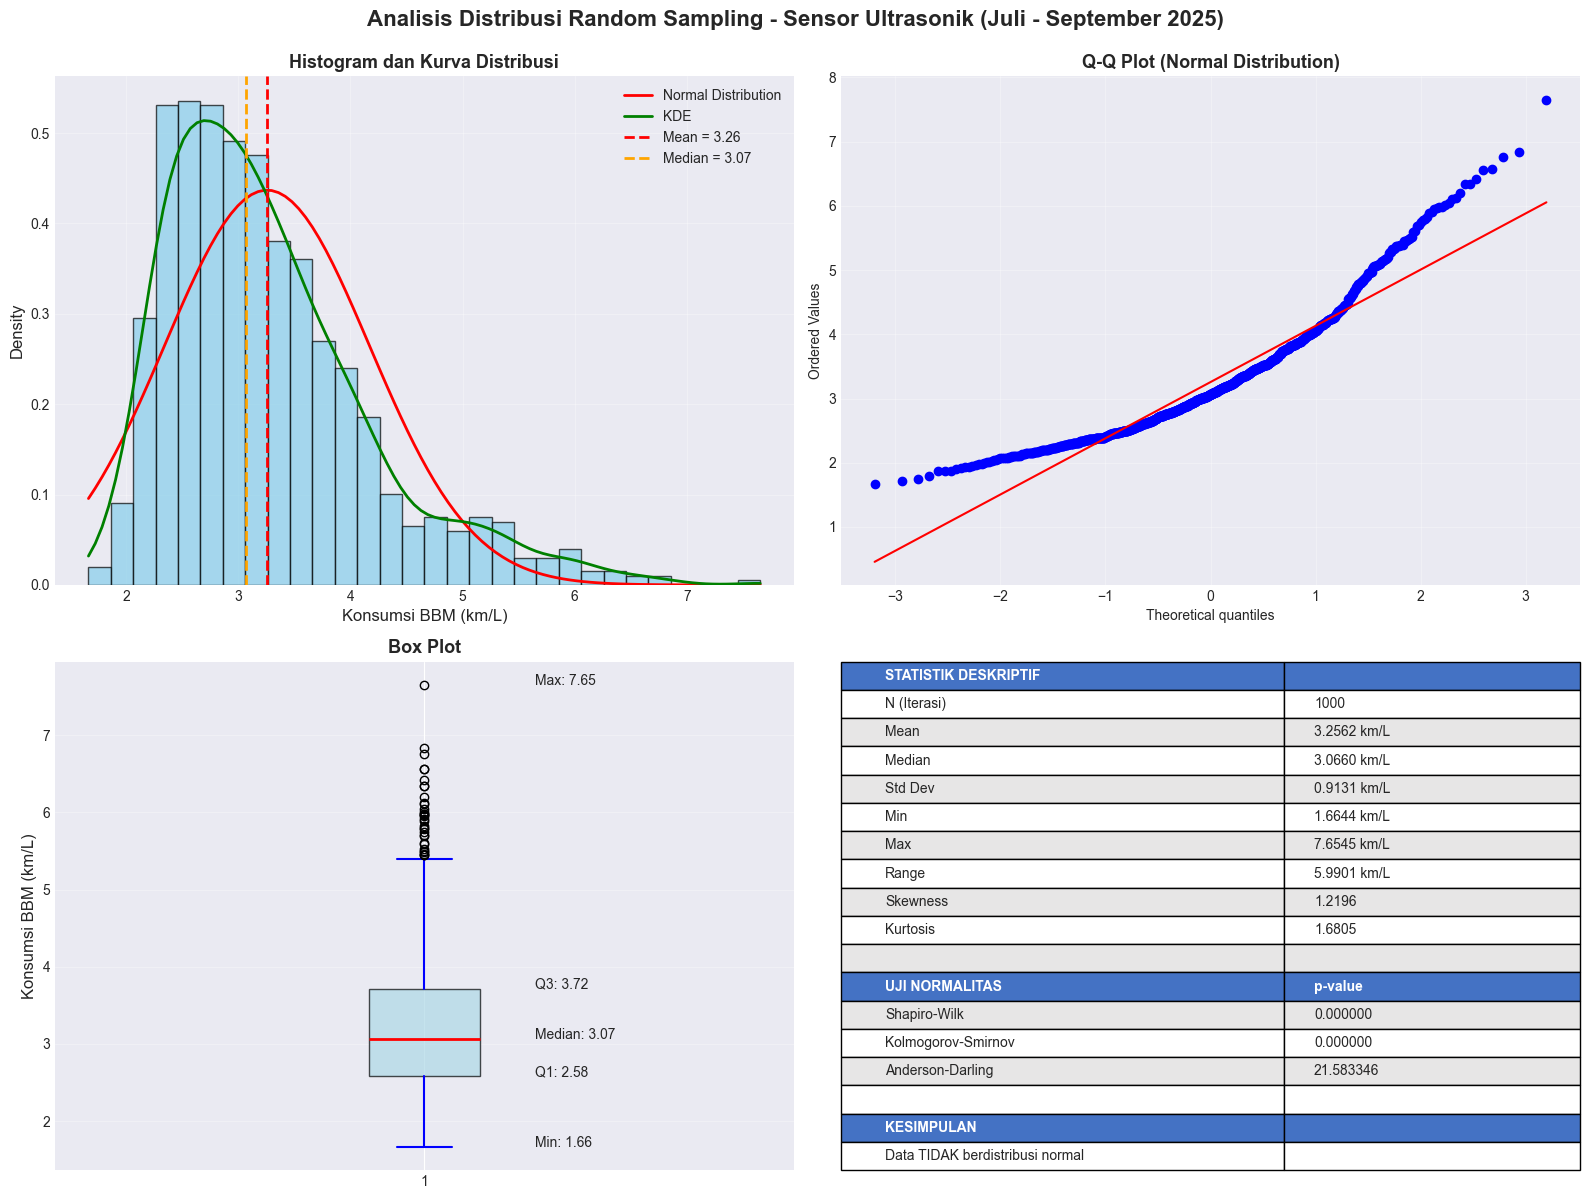


Visualisasi distribusi sampling berhasil ditampilkan


In [ ]:
# ============================================================================
# CELL 14: VISUALISASI DISTRIBUSI HASIL SAMPLING
# ============================================================================

def plot_sampling_distribution(sampling_df, stats_dict, normality_dict, title_suffix=""):
    """
    Plot distribusi hasil random sampling dengan 4 subplot
    """
    if len(sampling_df) == 0:
        print("WARNING: Tidak ada data untuk divisualisasi!")
        return None
    
    means = sampling_df['mean'].values
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Analisis Distribusi Random Sampling {title_suffix}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Histogram dengan KDE
    ax1 = axes[0, 0]
    ax1.hist(means, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    
    mu, sigma = stats_dict['Mean'], stats_dict['Std_Dev']
    x = np.linspace(means.min(), means.max(), 100)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
    
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(means)
    ax1.plot(x, kde(x), 'g-', linewidth=2, label='KDE')
    
    ax1.axvline(stats_dict['Mean'], color='red', linestyle='--', linewidth=2, label=f"Mean = {stats_dict['Mean']:.2f}")
    ax1.axvline(stats_dict['Median'], color='orange', linestyle='--', linewidth=2, label=f"Median = {stats_dict['Median']:.2f}")
    
    ax1.set_xlabel('Konsumsi BBM (km/L)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Histogram dan Kurva Distribusi', fontsize=13, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Q-Q Plot
    ax2 = axes[0, 1]
    stats.probplot(means, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot (Normal Distribution)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Box Plot
    ax3 = axes[1, 0]
    bp = ax3.boxplot(means, vert=True, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='blue', linewidth=1.5),
                     capprops=dict(color='blue', linewidth=1.5))
    
    ax3.set_ylabel('Konsumsi BBM (km/L)', fontsize=12)
    ax3.set_title('Box Plot', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    ax3.text(1.15, stats_dict['Max'], f"Max: {stats_dict['Max']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Q3'], f"Q3: {stats_dict['Q3']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Median'], f"Median: {stats_dict['Median']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Q1'], f"Q1: {stats_dict['Q1']:.2f}", fontsize=10, ha='left')
    ax3.text(1.15, stats_dict['Min'], f"Min: {stats_dict['Min']:.2f}", fontsize=10, ha='left')
    
    # Tabel Statistik dan Uji Normalitas
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    table_data = [
        ['STATISTIK DESKRIPTIF', ''],
        ['N (Iterasi)', f"{stats_dict['N']}"],
        ['Mean', f"{stats_dict['Mean']:.4f} km/L"],
        ['Median', f"{stats_dict['Median']:.4f} km/L"],
        ['Std Dev', f"{stats_dict['Std_Dev']:.4f} km/L"],
        ['Min', f"{stats_dict['Min']:.4f} km/L"],
        ['Max', f"{stats_dict['Max']:.4f} km/L"],
        ['Range', f"{stats_dict['Range']:.4f} km/L"],
        ['Skewness', f"{stats_dict['Skewness']:.4f}"],
        ['Kurtosis', f"{stats_dict['Kurtosis']:.4f}"],
        ['', ''],
        ['UJI NORMALITAS', 'p-value'],
        ['Shapiro-Wilk', f"{normality_dict['shapiro_p_value']:.6f}"],
        ['Kolmogorov-Smirnov', f"{normality_dict['ks_p_value']:.6f}"],
        ['Anderson-Darling', f"{normality_dict['anderson_statistic']:.6f}"],
        ['', ''],
        ['KESIMPULAN', ''],
        [normality_dict['conclusion'], '']
    ]
    
    table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4], bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    for i in range(len(table_data)):
        if i in [0, 11, 16]:
            for j in range(2):
                table[(i, j)].set_facecolor('#4472C4')
                table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            for j in range(2):
                table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')
    
    plt.tight_layout()
    return fig


# PLOT DISTRIBUSI SAMPLING
if len(sampling_results_baru) > 0:
    fig_sampling = plot_sampling_distribution(
        sampling_results_baru,
        stats_sampling_baru,
        normality_sampling_baru,
        title_suffix="- Sensor Ultrasonik (Juli - September 2025)"
    )
    plt.show()
    print("\nVisualisasi distribusi sampling berhasil ditampilkan")
else:
    print("\nTidak ada data untuk divisualisasi")

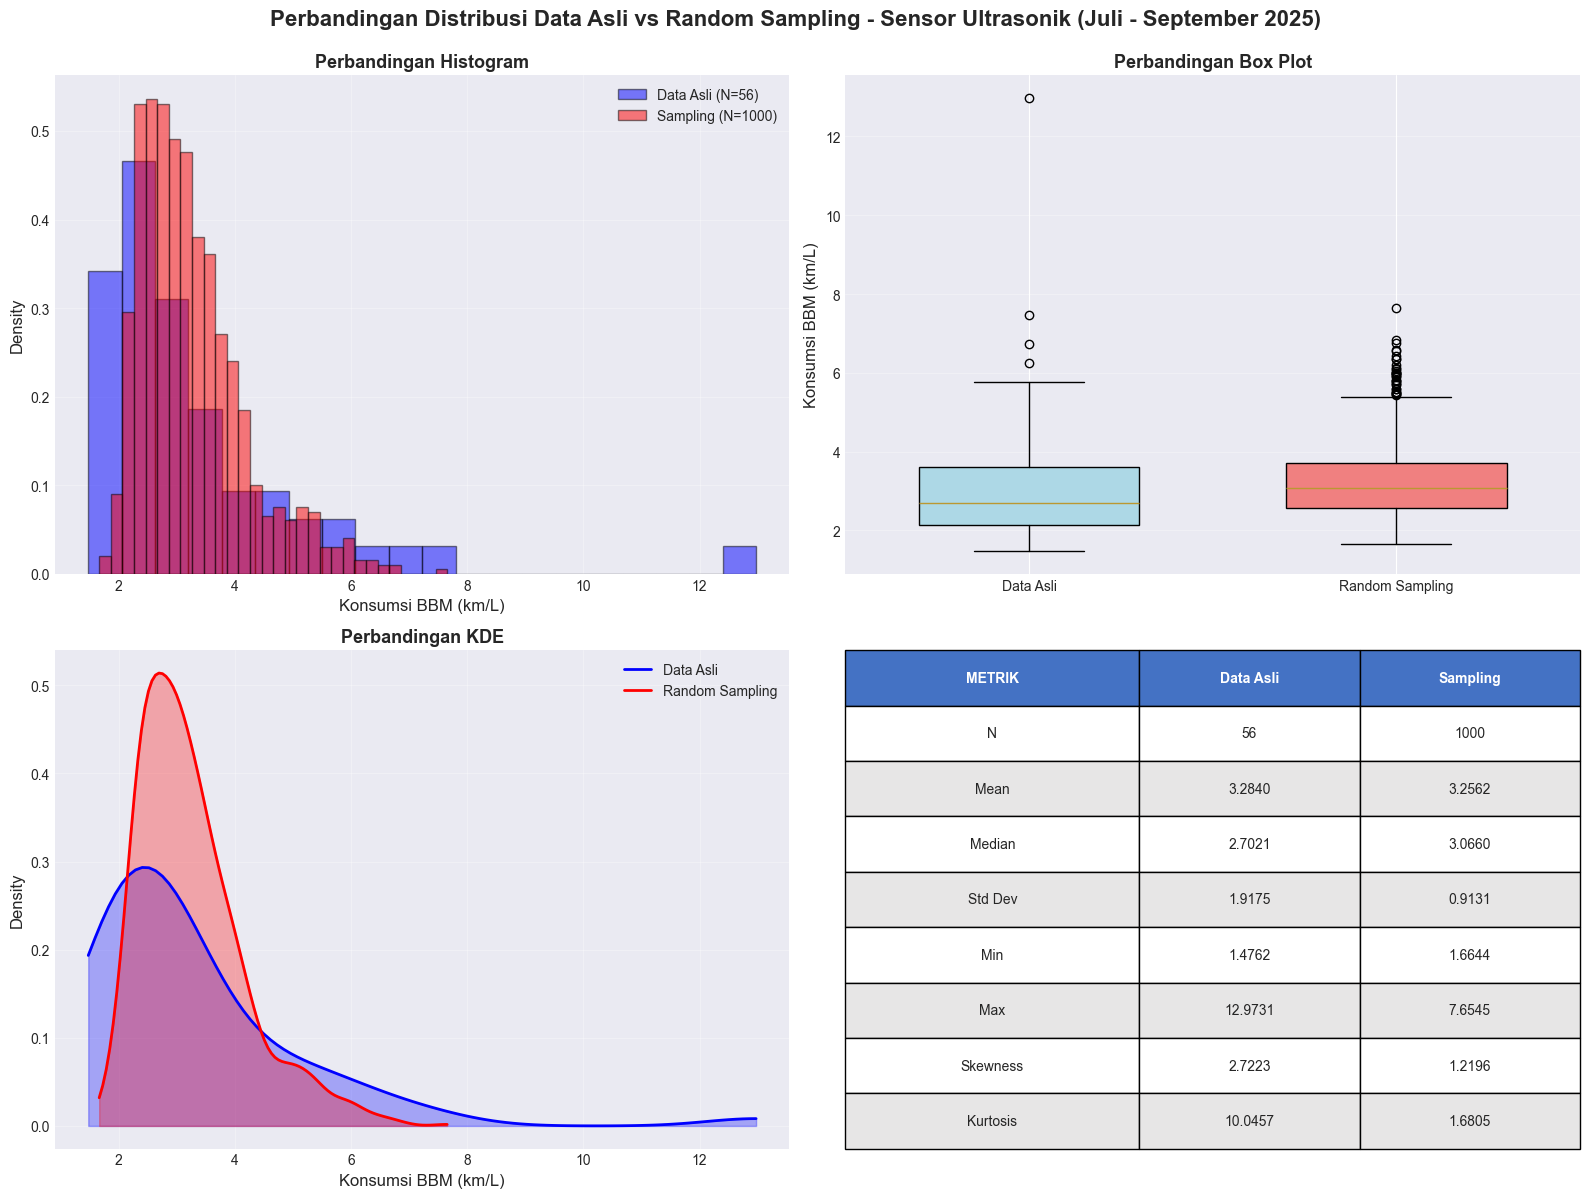


Visualisasi perbandingan berhasil ditampilkan


In [ ]:
# ============================================================================
# CELL 15: VISUALISASI PERBANDINGAN DISTRIBUSI
# ============================================================================

def plot_comparison_distribution(daily_df, sampling_df, title_suffix=""):
    """
    Plot perbandingan distribusi data asli vs hasil sampling
    """
    if len(daily_df) == 0 or len(sampling_df) == 0:
        print("WARNING: Tidak ada data untuk divisualisasi!")
        return None
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Perbandingan Distribusi Data Asli vs Random Sampling {title_suffix}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    original_data = daily_df['avg_consumption_kmL'].values
    sampled_means = sampling_df['mean'].values
    
    # Histogram Perbandingan
    ax1 = axes[0, 0]
    ax1.hist(original_data, bins=20, density=True, alpha=0.5, color='blue', 
             edgecolor='black', label=f'Data Asli (N={len(original_data)})')
    ax1.hist(sampled_means, bins=30, density=True, alpha=0.5, color='red', 
             edgecolor='black', label=f'Sampling (N={len(sampled_means)})')
    ax1.set_xlabel('Konsumsi BBM (km/L)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('Perbandingan Histogram', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box Plot Perbandingan
    ax2 = axes[0, 1]
    bp = ax2.boxplot([original_data, sampled_means], 
                      labels=['Data Asli', 'Random Sampling'],
                      patch_artist=True,
                      widths=0.6)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    ax2.set_ylabel('Konsumsi BBM (km/L)', fontsize=12)
    ax2.set_title('Perbandingan Box Plot', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # KDE Plot Perbandingan
    ax3 = axes[1, 0]
    from scipy.stats import gaussian_kde
    kde_original = gaussian_kde(original_data)
    kde_sampling = gaussian_kde(sampled_means)
    
    x_original = np.linspace(original_data.min(), original_data.max(), 100)
    x_sampling = np.linspace(sampled_means.min(), sampled_means.max(), 100)
    
    ax3.plot(x_original, kde_original(x_original), 'b-', linewidth=2, label='Data Asli')
    ax3.plot(x_sampling, kde_sampling(x_sampling), 'r-', linewidth=2, label='Random Sampling')
    ax3.fill_between(x_original, kde_original(x_original), alpha=0.3, color='blue')
    ax3.fill_between(x_sampling, kde_sampling(x_sampling), alpha=0.3, color='red')
    ax3.set_xlabel('Konsumsi BBM (km/L)', fontsize=12)
    ax3.set_ylabel('Density', fontsize=12)
    ax3.set_title('Perbandingan KDE', fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Tabel Perbandingan Statistik
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    table_data = [
        ['METRIK', 'Data Asli', 'Sampling'],
        ['N', f"{len(original_data)}", f"{len(sampled_means)}"],
        ['Mean', f"{np.mean(original_data):.4f}", f"{np.mean(sampled_means):.4f}"],
        ['Median', f"{np.median(original_data):.4f}", f"{np.median(sampled_means):.4f}"],
        ['Std Dev', f"{np.std(original_data, ddof=1):.4f}", f"{np.std(sampled_means, ddof=1):.4f}"],
        ['Min', f"{np.min(original_data):.4f}", f"{np.min(sampled_means):.4f}"],
        ['Max', f"{np.max(original_data):.4f}", f"{np.max(sampled_means):.4f}"],
        ['Skewness', f"{stats.skew(original_data):.4f}", f"{stats.skew(sampled_means):.4f}"],
        ['Kurtosis', f"{stats.kurtosis(original_data):.4f}", f"{stats.kurtosis(sampled_means):.4f}"],
    ]
    
    table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.4, 0.3, 0.3], bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    for i in range(len(table_data)):
        if i == 0:
            for j in range(3):
                table[(i, j)].set_facecolor('#4472C4')
                table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            for j in range(3):
                table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')
    
    plt.tight_layout()
    return fig


# PLOT COMPARISON
if len(daily_baru_interpolated) > 0 and len(sampling_results_baru) > 0:
    fig_comparison = plot_comparison_distribution(
        daily_baru_interpolated,
        sampling_results_baru,
        title_suffix="- Sensor Ultrasonik (Juli - September 2025)"
    )
    plt.show()
    print("\nVisualisasi perbandingan berhasil ditampilkan")
else:
    print("\nTidak ada data untuk divisualisasi")

In [ ]:
# ============================================================================
# CELL 16: CONFIDENCE INTERVAL
# ============================================================================

def calculate_confidence_interval(sampling_df, confidence=0.95):
    """
    Menghitung confidence interval dari hasil sampling
    """
    print("\n" + "="*80)
    print(f"CONFIDENCE INTERVAL ({confidence*100:.0f}%)")
    print("="*80)
    
    if len(sampling_df) == 0:
        print("\nWARNING: Tidak ada data sampling!")
        print("="*80)
        return {}
    
    means = sampling_df['mean'].values
    n = len(means)
    mean = np.mean(means)
    std = np.std(means, ddof=1)
    
    # Standard Error
    se = std / np.sqrt(n)
    
    # Confidence Interval menggunakan t-distribution
    from scipy import stats as sp_stats
    alpha = 1 - confidence
    df = n - 1
    t_critical = sp_stats.t.ppf(1 - alpha/2, df)
    
    margin_error = t_critical * se
    ci_lower = mean - margin_error
    ci_upper = mean + margin_error
    
    print(f"\nParameter:")
    print(f"  - Confidence level   : {confidence*100:.0f}%")
    print(f"  - Sample size (N)    : {n}")
    print(f"  - Degrees of freedom : {df}")
    
    print(f"\nHasil Perhitungan:")
    print(f"  - Mean               : {mean:.4f} km/L")
    print(f"  - Std Deviation      : {std:.4f} km/L")
    print(f"  - Standard Error     : {se:.6f} km/L")
    print(f"  - t-critical         : {t_critical:.4f}")
    print(f"  - Margin of Error    : {margin_error:.4f} km/L")
    
    print(f"\nConfidence Interval:")
    print(f"  - Lower bound        : {ci_lower:.4f} km/L")
    print(f"  - Upper bound        : {ci_upper:.4f} km/L")
    print(f"  - Interval           : [{ci_lower:.4f}, {ci_upper:.4f}] km/L")
    
    print(f"\nInterpretasi:")
    print(f"  Dengan tingkat kepercayaan {confidence*100:.0f}%, rata-rata konsumsi BBM")
    print(f"  berada di antara {ci_lower:.4f} km/L dan {ci_upper:.4f} km/L")
    
    print("="*80)
    
    return {
        'mean': mean,
        'std': std,
        'se': se,
        't_critical': t_critical,
        'margin_error': margin_error,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'confidence': confidence
    }


# CALCULATE CONFIDENCE INTERVAL
ci_results_baru = calculate_confidence_interval(sampling_results_baru, confidence=0.95)


CONFIDENCE INTERVAL (95%)

Parameter:
  - Confidence level   : 95%
  - Sample size (N)    : 1000
  - Degrees of freedom : 999

Hasil Perhitungan:
  - Mean               : 3.2562 km/L
  - Std Deviation      : 0.9131 km/L
  - Standard Error     : 0.028874 km/L
  - t-critical         : 1.9623
  - Margin of Error    : 0.0567 km/L

Confidence Interval:
  - Lower bound        : 3.1995 km/L
  - Upper bound        : 3.3128 km/L
  - Interval           : [3.1995, 3.3128] km/L

Interpretasi:
  Dengan tingkat kepercayaan 95%, rata-rata konsumsi BBM
  berada di antara 3.1995 km/L dan 3.3128 km/L
